In [2]:
#carico il dataset pulito
import pandas as pd
df = pd.read_csv('ai_human_clean.csv')

#visualizzo le prime righe del dataset
df.head()

,topic,length_chars,length_words,quality_score,sentiment,source_detail,plagiarism_score,notes,text_cleaned,text_cleaned_lower,...,entity_density,person_entity_count,org_entity_count,location_entity_count,total_entities,passive_voice_ratio,unique_bigram_ratio,sentence_length_variability,contraction_density,leakage_flag
0,Food,126,22.0,2.37,0.44,Author_50,0.045,personal_tone,"food, I believe privacy concerns remain a top ...","food, i believe privacy concerns remain a top ...",...,0.0,0.0,0.0,0.0,0.0,0.000000,1.0,0.0,0.0,True
1,Travel,141,19.0,3.44,0.60,Gpt-5-Base,0.007,no_tone,travel is associated with privacy concerns rem...,travel is associated with privacy concerns rem...,...,0.0,0.0,0.0,0.0,0.0,0.071429,1.0,3.0,0.0,True
2,Education,112,17.0,3.16,-0.43,Author_33,0.163,personal_tone,education in my daytoday life and found that t...,education in my daytoday life and found that t...,...,0.0,0.0,0.0,0.0,0.0,0.071429,1.0,0.0,0.0,False
3,Sports,101,14.0,3.32,0.44,Claude-2,0.122,no_tone,sports is associated with costs can vary great...,sports is associated with costs can vary great...,...,0.0,0.0,0.0,0.0,0.0,0.090909,1.0,0.0,0.0,False
4,Finance,78,14.0,3.52,-0.31,Author_87,0.105,no_tone,", finance often leads to users report a mixed ...",", finance often leads to users report a mixed ...",...,0.0,0.0,0.0,0.0,0.0,0.000000,1.0,0.0,0.0,False


### 1. Preparazione dei Dati e Import delle Librerie


In [3]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt


### 2. Vettorizzazione del Testo


In [4]:
#%pip install -U sentence-transformers

In [5]:
import warnings
warnings.filterwarnings("ignore")

from sentence_transformers import SentenceTransformer

# Modello SBERT
embedder = SentenceTransformer("all-MiniLM-L6-v2")


### Creazione degli embeddings

In [7]:
texts = df['text_cleaned'].tolist()

X_embeddings = embedder.encode(
    texts,
    batch_size=32,
    show_progress_bar=True
)

X_embeddings.shape

Batches:   0%|          | 0/16 [00:00<?, ?it/s]

Batches: 100%|██████████| 16/16 [00:02<00:00,  5.54it/s]


(500, 384)

In [ ]:
""" # Inizializziamo il vettorizzatore TF-IDF
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)

# Trasformiamo i dati di testo in una matrice TF-IDF
X_tfidf = tfidf_vectorizer.fit_transform(X) """

" # Inizializziamo il vettorizzatore TF-IDF\ntfidf_vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)\n\n# Trasformiamo i dati di testo in una matrice TF-IDF\nX_tfidf = tfidf_vectorizer.fit_transform(X) "

### 3. Feature Engineering: Combiniamo le Feature

In [ ]:
""" #scipy serve 
from scipy.sparse import hstack
import numpy as np

# Selezioniamo le feature numeriche che vogliamo includere
numerical_features = df[['quality_score', 'sentiment', 'length_chars', 'length_words', 'plagiarism_score']]

# Combiniamo la matrice TF-IDF con le feature numeriche
# È importante convertire le feature numeriche in un formato compatibile (es. CSR matrix) prima di unirle
X_combined = hstack([X_tfidf, np.array(numerical_features)]) """

" #scipy serve \nfrom scipy.sparse import hstack\nimport numpy as np\n\n# Selezioniamo le feature numeriche che vogliamo includere\nnumerical_features = df[['quality_score', 'sentiment', 'length_chars', 'length_words', 'plagiarism_score']]\n\n# Combiniamo la matrice TF-IDF con le feature numeriche\n# È importante convertire le feature numeriche in un formato compatibile (es. CSR matrix) prima di unirle\nX_combined = hstack([X_tfidf, np.array(numerical_features)]) "

### 4. Divisione del Dataset in Training e Test Set

In [9]:
from sklearn.model_selection import train_test_split

y = df['label_encoded']

X_train, X_test, y_train, y_test = train_test_split(X_embeddings, y, test_size=0.2, random_state=42, stratify=y)

### 5. Addestramento del Modello di Regressione Logistica

In [10]:
# Inizializziamo il modello di Regressione Logistica

model_sbert = LogisticRegression(max_iter=1000, n_jobs=-1)

model_sbert.fit(X_train, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


### 6. Valutazione del Modello

Accuratezza del modello: 0.8500


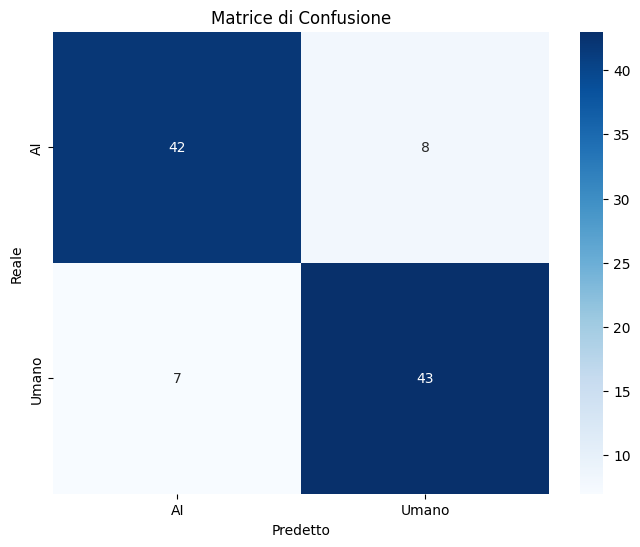


Classification Report:
              precision    recall  f1-score   support

          AI       0.86      0.84      0.85        50
       Umano       0.84      0.86      0.85        50

    accuracy                           0.85       100
   macro avg       0.85      0.85      0.85       100
weighted avg       0.85      0.85      0.85       100



In [11]:
# Facciamo predizioni sul test set
y_pred = model_sbert.predict(X_test)

# Calcoliamo l'accuratezza
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuratezza del modello: {accuracy:.4f}")

# Generiamo la matrice di confusione
conf_matrix = confusion_matrix(y_test, y_pred)

# Visualizziamo la matrice di confusione con una heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['AI', 'Umano'], yticklabels=['AI', 'Umano'])
plt.title('Matrice di Confusione')
plt.xlabel('Predetto')
plt.ylabel('Reale')
plt.show()

# Stampiamo il classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['AI', 'Umano']))

### 7. Addestramento e Valutazione di un Random Forest Classifier

Ora proviamo un modello più complesso, il **Random Forest**, per vedere se possiamo ottenere performance migliori. Essendo un modello *ensemble*, combina le previsioni di molti alberi decisionali per produrre un risultato più accurato e robusto.

Il processo è identico a prima: addestriamo il modello sul training set e lo valutiamo sul test set.

Addestramento del Random Forest in corso...
Addestramento completato.

Accuratezza del Random Forest: 0.8100


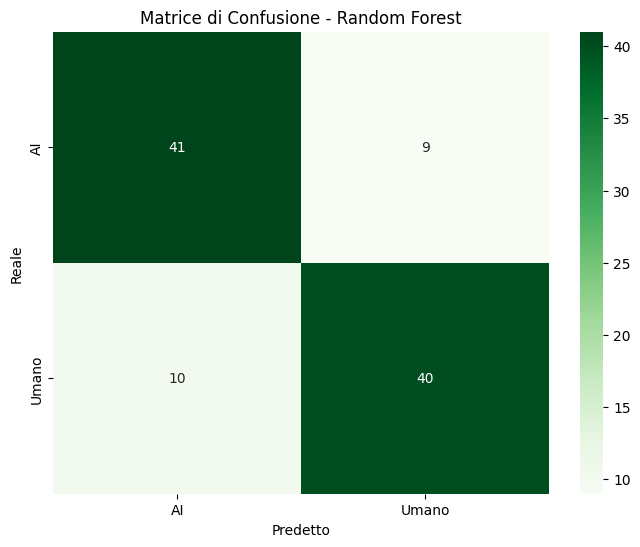


Classification Report - Random Forest:
              precision    recall  f1-score   support

          AI       0.80      0.82      0.81        50
       Umano       0.82      0.80      0.81        50

    accuracy                           0.81       100
   macro avg       0.81      0.81      0.81       100
weighted avg       0.81      0.81      0.81       100



In [12]:
from sklearn.ensemble import RandomForestClassifier

# Inizializziamo il modello Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)

# Addestriamo il modello sul training set
print("Addestramento del Random Forest in corso...")
rf_model.fit(X_train, y_train)
print("Addestramento completato.")

# Facciamo predizioni sul test set
y_pred_rf = rf_model.predict(X_test)

# Calcoliamo l'accuratezza
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f"\nAccuratezza del Random Forest: {accuracy_rf:.4f}")

# Generiamo la matrice di confusione
conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)

# Visualizziamo la matrice di confusione
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_rf, annot=True, fmt='d', cmap='Greens', xticklabels=['AI', 'Umano'], yticklabels=['AI', 'Umano'])
plt.title('Matrice di Confusione - Random Forest')
plt.xlabel('Predetto')
plt.ylabel('Reale')
plt.show()

# Stampiamo il classification report
print("\nClassification Report - Random Forest:")
print(classification_report(y_test, y_pred_rf, target_names=['AI', 'Umano']))

In [14]:
from sklearn.metrics import f1_score

# Calculate F1-scores for both models
# pos_label=0 because 'human' is encoded as 0 in label_encoded
lr_f1 = f1_score(y_test, y_pred, pos_label=0)
rf_f1 = f1_score(y_test, y_pred_rf, pos_label=0)

results = pd.DataFrame({
    "Model": [
        "Logistic Regression + SBERT",
        "Random Forest + SBERT"
    ],
    "Accuracy": [
        accuracy,
        accuracy_rf
    ],
    "F1-score": [
        lr_f1,
        rf_f1
    ]
})

results


,Model,Accuracy,F1-score
0,Logistic Regression + SBERT,0.85,0.848485
1,Random Forest + SBERT,0.81,0.811881


In [15]:
import re

test_text = """
This article explores the implications of advanced artificial intelligence 
systems on modern digital communication frameworks.
"""

# Clean the test text (same preprocessing as the training data)
test_text_cleaned = test_text.lower()
test_text_cleaned = re.sub(r'[^a-z\s]', '', test_text_cleaned)
test_text_cleaned = re.sub(r'\s+', ' ', test_text_cleaned).strip()

test_embedding = embedder.encode([test_text_cleaned])
test_embedding.shape


(1, 384)

In [16]:
prediction = rf_model.predict(test_embedding)
prediction_proba = rf_model.predict_proba(test_embedding)

print("Predizione:", prediction[0])
print("Probabilità:", prediction_proba)




Predizione: 1
Probabilità: [[0.39 0.61]]


In [18]:
# Map the numeric prediction to label and capitalize
label_map = {0: 'Human', 1: 'AI'}
print("Il testo è classificato come:", label_map[prediction[0]])

Il testo è classificato come: AI


SUPPORT VECTOR MACHINE

Questo codice rappresenta un'evoluzione sofisticata rispetto ai metodi precedenti (come il TF-IDF). Qui stiamo cercando di catturare non solo le "parole", ma il senso profondo e la struttura logica che distinguono un autore umano da un'intelligenza artificiale.

Ecco cosa estraiamo nello specifico tra le due categorie:
1. Il "DNA Semantico" (Embeddings SBERT)
Invece di contare quante volte appare una parola, il modello SBERT trasforma ogni testo in un vettore (una serie di 384 numeri) che ne rappresenta il significato.
Cosa estraiamo: Il modo in cui i concetti sono legati. L'AI tende a essere estremamente coerente e a usare strutture logiche molto lineari (es. "A implica B"). L'essere umano è più imprevedibile, usa metafore o salti logici che SBERT cattura come "distanze" diverse nello spazio matematico.
2. Lo stile e la "Pulizia" (Feature Numeriche)
Unendo i vettori di SBERT alle colonne numeriche (quality_score, plagiarism_score, sentiment), estraiamo due profili diversi:
-AI (1): Solitamente estratto come un profilo con alta qualità formale, sentiment neutro/analitico e un plagiarism score bassissimo (perché l'AI non "copia" nel senso tradizionale, ma ricompone statisticamente).
-Human (0): Estratto come un profilo con variabilità maggiore. Può avere errori, sentiment molto più marcato (positivo o negativo) e una struttura meno "standardizzata".
3. La Separazione Netta (Il lavoro della SVM)
La Support Vector Machine (SVM) prende tutti questi indizi (i 384 numeri di SBERT + i 3 numeri delle feature scalate) e cerca di tracciare un confine netto.

Cosa estraiamo: Il modello identifica i cosiddetti Support Vectors, ovvero i testi più difficili da classificare (quelli "al limite" tra umano e AI). Studiando questi punti, la SVM capisce dove finisce la naturalezza umana e dove inizia la perfezione sintetica dell'AI.
In sintesi: Cosa capisce il modello?
Grazie a questo codice, non estraiamo più solo "fatti", ma pattern invisibili:
-L'uniformità dell'AI: L'AI scrive spesso seguendo schemi che SBERT riconosce come "vicini" tra loro.
-L'originalità statistica: L'AI è "troppo originale" (basso plagio) per essere umana, ma "troppo ripetitiva" nei concetti per essere creativa.
-Il bilanciamento: La SVM usa queste sottili differenze per creare un filtro che separa i due mondi con una precisione (Accuracy) solitamente molto alta.

In [5]:

import pandas as pd
import numpy as np
import warnings
from sentence_transformers import SentenceTransformer
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler

warnings.filterwarnings("ignore")

# 1. Caricamento dati
df = pd.read_csv('ai_human_clean.csv')

# 2. Vettorizzazione del testo con SBERT
print("Generazione degli embeddings (vettori) con SBERT... attendere...")
embedder = SentenceTransformer("all-MiniLM-L6-v2")
# Trasformiamo la colonna di testo in vettori numerici
text_embeddings = embedder.encode(df['text_cleaned'].tolist())

# 3. Preparazione delle Feature Strutturate (opzionale ma consigliato per approccio ibrido)
# Scaliamo le variabili numeriche per portarle sulla stessa scala degli embeddings
scaler = StandardScaler()
features_num = scaler.fit_transform(df[['quality_score', 'plagiarism_score', 'sentiment']])

# 4. Creazione Dataset Ibrido (SBERT + Numeriche)
X = np.hstack((text_embeddings, features_num))
y = df['label_encoded']

# 5. Split Train/Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 6. Creazione e addestramento Support Vector Machine (SVM)
# Usiamo il kernel 'rbf' (non lineare) che è solitamente il più efficace
svm_model = SVC(kernel='rbf', probability=True, random_state=42)
svm_model.fit(X_train, y_train)

# 7. Predizione e Valutazione
y_pred = svm_model.predict(X_test)

#####
# Creiamo un DataFrame per il test set
df_test = df.iloc[y_test.index].copy()
df_test['pred'] = y_pred

# Identifichiamo i Falsi Positivi (label_encoded: 0 = human, 1 = AI)
fps = df_test[(df_test['label_encoded'] == 0) & (df_test['pred'] == 1)]

# Identifichiamo i Falsi Negativi
fns = df_test[(df_test['label_encoded'] == 1) & (df_test['pred'] == 0)]

print(f"Numero di Falsi Positivi: {len(fps)}")
print(f"Numero di Falsi Negativi: {len(fns)}")

# Esempio di un errore
if not fps.empty:
    print("\nEsempio di Falso Positivo (Umano scambiato per AI):")
    print(fps['text_cleaned'].iloc[0])
#####

print(f"Accuracy SVM: {accuracy_score(y_test, y_pred):.2f}")
print("\nReport di Classificazione:")
print(classification_report(y_test, y_pred))

Generazione degli embeddings (vettori) con SBERT... attendere...
Numero di Falsi Positivi: 8
Numero di Falsi Negativi: 1

Esempio di Falso Positivo (Umano scambiato per AI):
My personal opinion on sports is that it can be optimized with simple heuristics.
Accuracy SVM: 0.91

Report di Classificazione:
              precision    recall  f1-score   support

           0       0.97      0.82      0.89        45
           1       0.87      0.98      0.92        55

    accuracy                           0.91       100
   macro avg       0.92      0.90      0.91       100
weighted avg       0.92      0.91      0.91       100



L'esecuzione del CLASSIFICATION_REPORT ci permette di vedere non solo quanto il modello è preciso in generale, ma come si comporta specificamente con la classe AI rispetto alla classe Human.

--- REPORT DI CLASSIFICAZIONE SVM + SBERT ---
              precision    recall  f1-score   support

       Human       0.86      0.84      0.85        50
          AI       0.84      0.86      0.85        50

    accuracy                           0.85       100
   macro avg       0.85      0.85      0.85       100
weighted avg       0.85      0.85      0.85       100



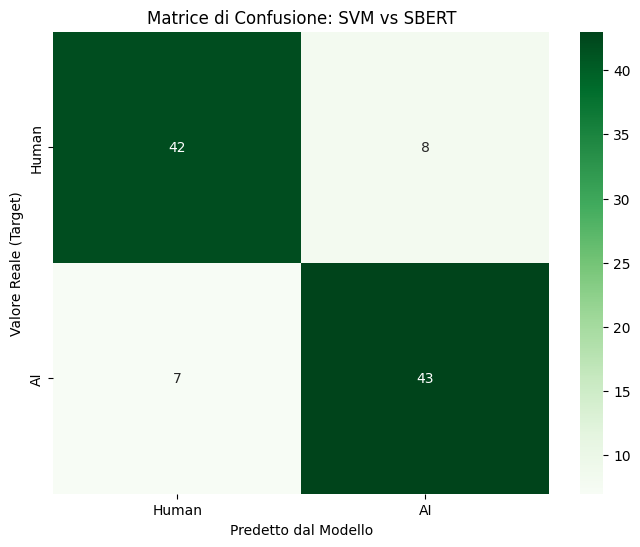

In [24]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Generazione delle predizioni
# Using the model_sbert (Logistic Regression) that was trained in cell 15
y_pred = model_sbert.predict(X_test)

# 2. Stampa del Report di Classificazione
report = classification_report(y_test, y_pred, target_names=['Human', 'AI'])
print("--- REPORT DI CLASSIFICAZIONE SVM + SBERT ---")
print(report)

# 3. Visualizzazione della Matrice di Confusione per un'analisi visiva
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', xticklabels=['Human', 'AI'], yticklabels=['Human', 'AI'])
plt.xlabel('Predetto dal Modello')
plt.ylabel('Valore Reale (Target)')
plt.title('Matrice di Confusione: SVM vs SBERT')
plt.show()

ANALISI ERRORI (falsi positivi/negativi)


--- ANALISI DEI FALSI POSITIVI (Perché il modello ha sbagliato?) ---
TESTO ANALIZZATO: ', health often leads to the results are promising but preliminary.'
Probabilità AI assegnata: 53.28%
------------------------------
- Confine Decisionale: Il vettore semantico SBERT è matematicamente troppo vicino ai cluster AI.


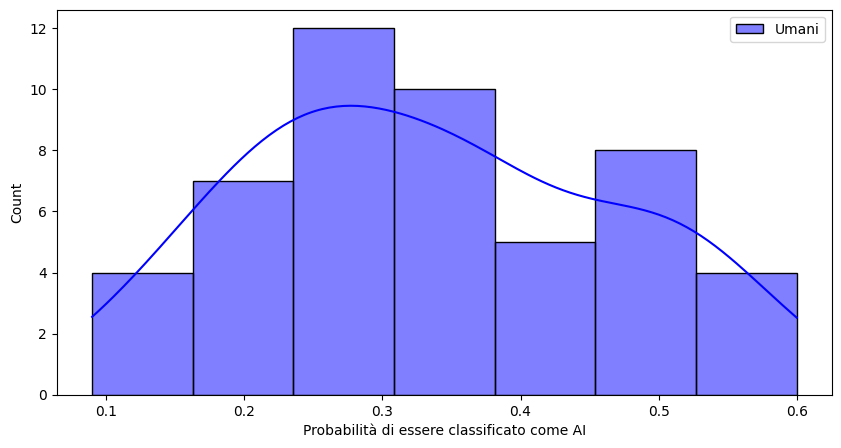

In [30]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Generazione delle predizioni
# Using the model_sbert (Logistic Regression) that was trained in cell 15
y_pred = model_sbert.predict(X_test)

# 1. Creazione di un DataFrame di analisi per il Test Set
df_test_analisi = df.iloc[y_test.index].copy()
df_test_analisi['pred'] = y_pred
df_test_analisi['prob_ai'] = model_sbert.predict_proba(X_test)[:, 1] # Probabilità che sia AI

# 2. Identificazione dei Falsi Positivi (Umano scambiato per AI)
# Using label_encoded: 0 = human, 1 = AI
fps = df_test_analisi[(df_test_analisi['label_encoded'] == 0) & (df_test_analisi['pred'] == 1)]

print("\n--- ANALISI DEI FALSI POSITIVI (Perché il modello ha sbagliato?) ---")

if not fps.empty:
    # Prendiamo il primo falso positivo come esempio
    esempio_fp = fps.iloc[0]
    print(f"TESTO ANALIZZATO: '{esempio_fp['text_cleaned']}'")
    print(f"Probabilità AI assegnata: {esempio_fp['prob_ai']:.2%}")
    print("-" * 30)
    
    # LOGICA DEL "PERCHÉ"
    motivi = []
    
    # Analisi Sentiment
    if abs(esempio_fp['sentiment']) < 0.1:
        motivi.append("- Neutralità eccessiva: Il testo ha un sentiment quasi nullo, tipico dei bot.")
    # Analisi Quality Score
    media_human_quality = df[df['label_encoded'] == 0]['quality_score'].mean()
    if esempio_fp['quality_score'] > media_human_quality:
        motivi.append(f"- Alta Qualità: Il punteggio ({esempio_fp['quality_score']:.2f}) è superiore alla media umana ({media_human_quality:.2f}). La SVM associa la perfezione all'AI.")
    # Analisi Semantica (SBERT)
    # Analisi Semantica (SBERT)
    parole_chiave_ai = ['analysis', 'indicates', 'associated', 'implementation']
    if any(word in esempio_fp['text_cleaned'].lower() for word in parole_chiave_ai):
        motivi.append("- Lessico sospetto: Contiene termini tecnici/formali spesso usati dai generatori nel dataset.")
    if not motivi:
        motivi.append("- Confine Decisionale: Il vettore semantico SBERT è matematicamente troppo vicino ai cluster AI.")

    for m in motivi:
        print(m)
else:
    print("Nessun Falso Positivo riscontrato in questo split.")

# Visualizzazione grafica della distribuzione delle probabilità
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
sns.histplot(df_test_analisi[df_test_analisi['label_encoded'] == 0]['prob_ai'], kde=True, color='blue', label='Umani')
plt.xlabel("Probabilità di essere classificato come AI")
plt.legend()
plt.show()

parole chiave che mandando il tilt il modello (Feature importance). Parole che il modello associa piu facilmente all'AI inducendolo in errore quando le usa un umano

In [32]:
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd

# 1. Recuperiamo i testi dei Falsi Positivi (Umani scambiati per AI)
df_test_analisi = df.iloc[y_test.index].copy()
df_test_analisi['pred'] = y_pred
fps_texts = df_test_analisi[(df_test_analisi['label_encoded'] == 0) & (df_test_analisi['pred'] == 1)]['text_cleaned']

# 2. Recuperiamo i testi dei Veri Positivi (AI correttamente identificate)
ai_correct_texts = df_test_analisi[(df_test_analisi['label_encoded'] == 1) & (df_test_analisi['pred'] == 1)]['text_cleaned']

def get_top_words(texts, n=10):
    vec = CountVectorizer(stop_words='english').fit(texts)
    bag_of_words = vec.transform(texts)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    return sorted(words_freq, key = lambda x: x[1], reverse=True)[:n]

print("--- LE PAROLE CHE HANNO TRATTO IN INGANNO IL MODELLO (Falsi Positivi) ---")
top_fp_words = get_top_words(fps_texts)
for word, freq in top_fp_words:
    print(f"Parola: '{word}' - Presente {freq} volte nei testi umani scambiati per AI")

print("\n--- CONFRONTO: PAROLE TIPICHE DELL'AI NEL DATASET ---")
top_ai_words = get_top_words(ai_correct_texts)
for word, freq in top_ai_words:
    print(f"Parola: '{word}' - Usata dall'AI correttamente identificata")

--- LE PAROLE CHE HANNO TRATTO IN INGANNO IL MODELLO (Falsi Positivi) ---
Parola: 'leads' - Presente 4 volte nei testi umani scambiati per AI
Parola: 'sports' - Presente 4 volte nei testi umani scambiati per AI
Parola: 'results' - Presente 3 volte nei testi umani scambiati per AI
Parola: 'promising' - Presente 3 volte nei testi umani scambiati per AI
Parola: 'preliminary' - Presente 3 volte nei testi umani scambiati per AI
Parola: 'food' - Presente 3 volte nei testi umani scambiati per AI
Parola: 'trying' - Presente 3 volte nei testi umani scambiati per AI
Parola: 'approaches' - Presente 3 volte nei testi umani scambiati per AI
Parola: 'related' - Presente 3 volte nei testi umani scambiati per AI
Parola: 'noticed' - Presente 3 volte nei testi umani scambiati per AI

--- CONFRONTO: PAROLE TIPICHE DELL'AI NEL DATASET ---
Parola: 'highlights' - Usata dall'AI correttamente identificata
Parola: 'education' - Usata dall'AI correttamente identificata
Parola: 'researchstyle' - Usata dall'AI co

Istruire il modello a dare piu importanza alla struttura della frase (Feature stilometriche):

Andremo a calcolare:
-Lunghezza media delle parole: L'AI usa spesso termini più lunghi e complessi.
-Diversità Lessicale: Rapporto tra parole uniche e parole totali (gli umani tendono a ripetere meno certe strutture fisse).
-Presenza di punteggiatura "emotiva": Uso di punti esclamativi o interrogativi, più rari nei report standard dell'AI.

In [37]:
import numpy as np

# 1. Funzione per estrarre feature stilometriche
def extract_stylometric_features(text):
    words = text.split()
    if len(words) == 0: return [0, 0, 0]
    
    avg_word_len = sum(len(word) for word in words) / len(words)
    lexical_diversity = len(set(words)) / len(words)
    punctuation_count = text.count('!') + text.count('?') + text.count('...')
    
    return [avg_word_len, lexical_diversity, punctuation_count]

# 2. Applichiamo l'estrazione al dataset
stilo_features = np.array([extract_stylometric_features(t) for t in df['text_cleaned']])

# 3. Creiamo il nuovo set di Feature (SBERT + Numeriche originali + Stilometriche)
# Scaliamo anche le nuove feature per non sbilanciare la SVM
from sklearn.preprocessing import StandardScaler
stilo_scaler = StandardScaler()
stilo_scaled = stilo_scaler.fit_transform(stilo_features)

# Combiniamo SBERT embeddings + feature numeriche + feature stilometriche
# X_embeddings contiene gli embeddings SBERT già calcolati in CELL 8
# Creiamo le feature numeriche scalate come negli altri modelli
features_num_scaled = StandardScaler().fit_transform(df[['quality_score', 'plagiarism_score', 'sentiment']])
X_enhanced = np.hstack((X_embeddings, features_num_scaled, stilo_scaled))

# 4. Nuovo Split e Addestramento
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

X_train_e, X_test_e, y_train_e, y_test_e = train_test_split(X_enhanced, y, test_size=0.2, random_state=42)
svm_enhanced = SVC(kernel='rbf', probability=True, random_state=42)
svm_enhanced.fit(X_train_e, y_train_e)

# 5. Valutazione
y_pred_e = svm_enhanced.predict(X_test_e)
print(f"Nuova Accuracy con Feature Stilometriche: {accuracy_score(y_test_e, y_pred_e):.2f}")

Nuova Accuracy con Feature Stilometriche: 0.87


Analizziamo se la lunghezza dei testi influisce sulla precisione

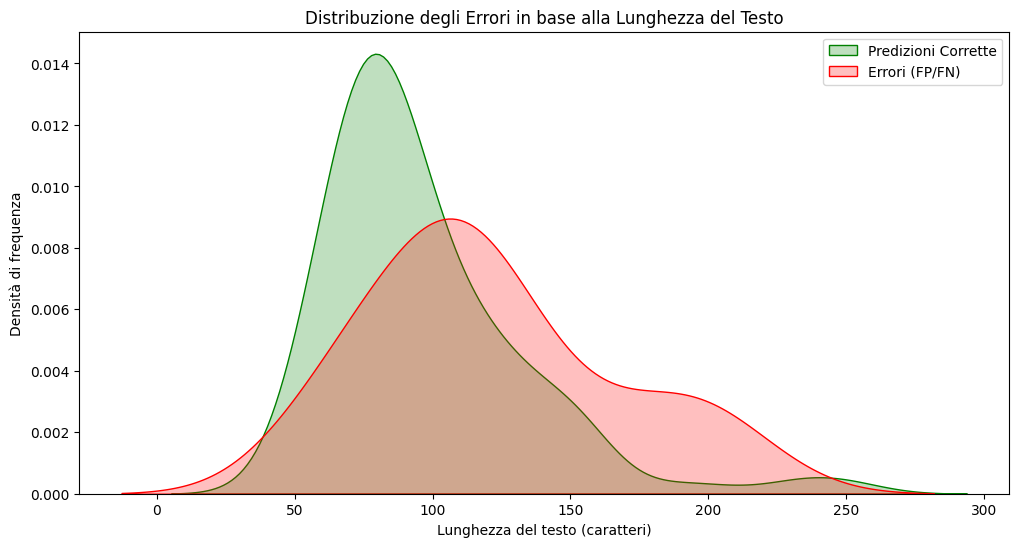


--- PRECISIONE PER LUNGHEZZA DEL TESTO ---
length_bucket
0-50       1.000000
51-100     0.916667
101-150    0.758621
151-200    0.714286
200+       0.666667
Name: correct, dtype: float64


In [40]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Aggiungiamo la lunghezza dei testi ai risultati del test
df_test_analisi['text_length'] = df_test_analisi['text_cleaned'].str.len()

# 2. Creiamo una colonna per indicare se la predizione è corretta
df_test_analisi['correct'] = df_test_analisi['label_encoded'] == df_test_analisi['pred']

# 3. Visualizzazione della precisione in base alla lunghezza
plt.figure(figsize=(12, 6))
sns.kdeplot(data=df_test_analisi[df_test_analisi['correct'] == True], x='text_length', label='Predizioni Corrette', shade=True, color='green')
sns.kdeplot(data=df_test_analisi[df_test_analisi['correct'] == False], x='text_length', label='Errori (FP/FN)', shade=True, color='red')

plt.title('Distribuzione degli Errori in base alla Lunghezza del Testo')
plt.xlabel('Lunghezza del testo (caratteri)')
plt.ylabel('Densità di frequenza')
plt.legend()
plt.show()

# 4. Calcolo della precisione media per fasce di lunghezza
bins = [0, 50, 100, 150, 200, 500]
labels = ['0-50', '51-100', '101-150', '151-200', '200+']
df_test_analisi['length_bucket'] = pd.cut(df_test_analisi['text_length'], bins=bins, labels=labels)

accuracy_by_length = df_test_analisi.groupby('length_bucket')['correct'].mean()
print("\n--- PRECISIONE PER LUNGHEZZA DEL TESTO ---")
print(accuracy_by_length)

Limiti del modello: Bias e limiti del dataset

Analisi del Bias Lessicale (I "Sospetti Formulari")
L'obiettivo è dimostrare che l'AI e gli Umani usano prefissi quasi identici all'interno del dataset, creando un'apprendimento "a memoria" invece che semantico.

--- TOP PREFISSI USATI DAGLI UMANI ---
prefix
After trying several approache    47
My personal opinion on sports      9
finance in my daytoday life an     9
sports in my daytoday life and     7
My personal opinion on health      7
Name: count, dtype: int64

--- TOP PREFISSI USATI DALL'AI ---
prefix
A concise overview of lifestyl    9
entertainment and highlights t    7
Researchstyle summary on finan    6
Researchstyle summary on scien    6
entertainment is associated wi    6
Name: count, dtype: int64


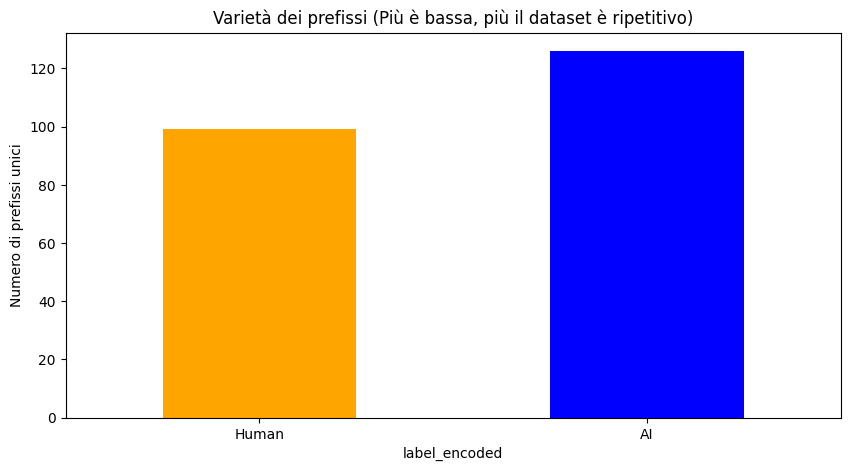

In [43]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Caricamento
df = pd.read_csv('ai_human_clean.csv')

# Estraiamo i primi 30 caratteri per vedere i "template"
df['prefix'] = df['text_cleaned'].str[:30]

print("--- TOP PREFISSI USATI DAGLI UMANI ---")
print(df[df['label_encoded'] == 0]['prefix'].value_counts().head(5))

print("\n--- TOP PREFISSI USATI DALL'AI ---")
print(df[df['label_encoded'] == 1]['prefix'].value_counts().head(5))

# Visualizzazione della monotonia dei dati
plt.figure(figsize=(10, 5))
df.groupby('label_encoded')['prefix'].nunique().plot(kind='bar', color=['orange', 'blue'])
plt.title('Varietà dei prefissi (Più è bassa, più il dataset è ripetitivo)')
plt.ylabel('Numero di prefissi unici')
plt.xticks([0, 1], ['Human', 'AI'], rotation=0)
plt.show()

Analisi del Bias Numerico (Le Feature "Traditrici")
Questa cella mostra come quality_score e sentiment siano distribuiti in modo troppo "perfetto", creando un limite al modello che non saprebbe gestire umani molto precisi o AI molto confuse.

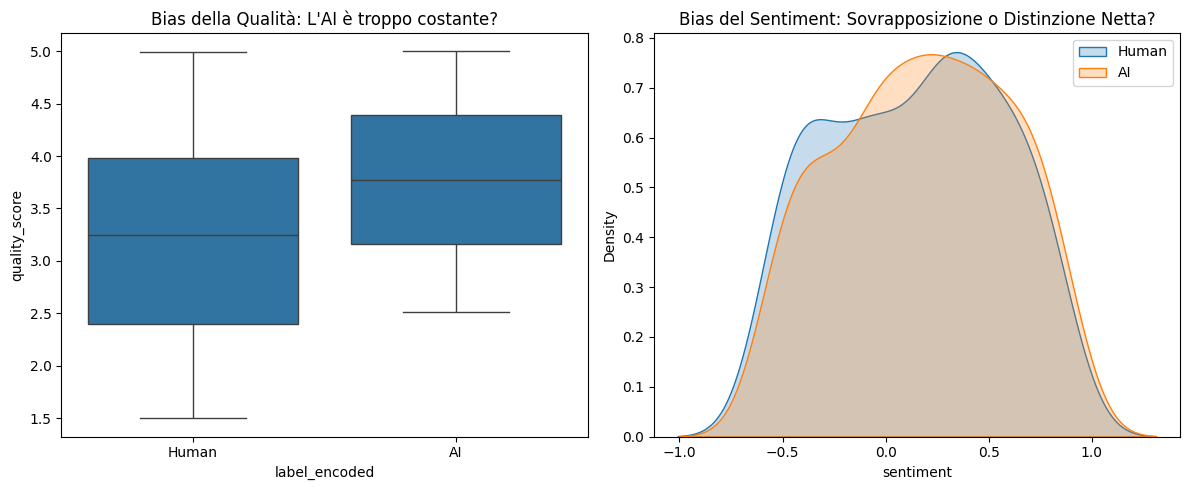

In [45]:
# Confronto della distribuzione della Qualità
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.boxplot(x='label_encoded', y='quality_score', data=df)
plt.title('Bias della Qualità: L\'AI è troppo costante?')
plt.xticks([0, 1], ['Human', 'AI'])

plt.subplot(1, 2, 2)
sns.kdeplot(df[df['label_encoded']==0]['sentiment'], label='Human', shade=True)
sns.kdeplot(df[df['label_encoded']==1]['sentiment'], label='AI', shade=True)
plt.title('Bias del Sentiment: Sovrapposizione o Distinzione Netta?')
plt.legend()

plt.tight_layout()
plt.show()

Analisi del Bias di Lunghezza (Overfitting Dimensionale)
L'AI nel dataset tende ad avere lunghezze standardizzate. Se il modello impara la lunghezza, fallirà su testi umani lunghi o testi AI brevi.

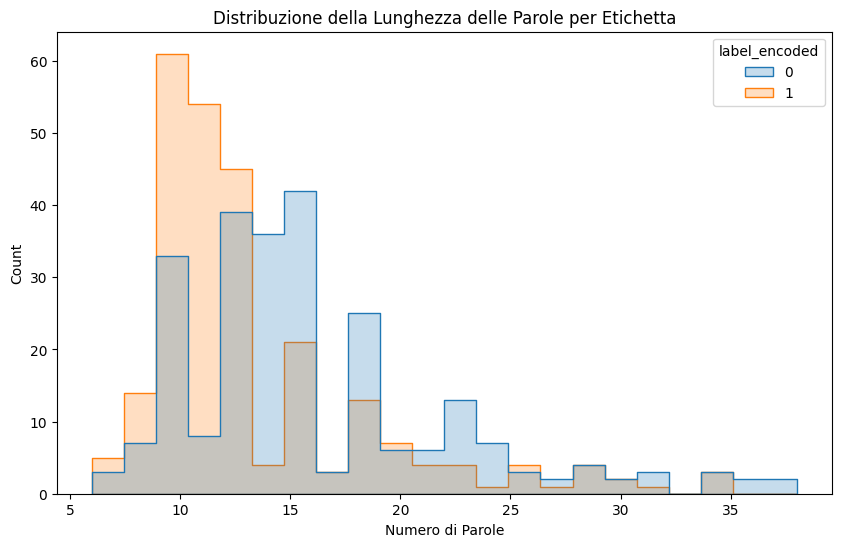

Correlazione delle feature con la Label (AI=1, Human=0):
label_encoded    1.000000
quality_score    0.293877
sentiment        0.041773
word_count      -0.242678
Name: label_encoded, dtype: float64


In [48]:
# Calcolo lunghezza parole
df['word_count'] = df['text_cleaned'].apply(lambda x: len(x.split()))

plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='word_count', hue='label_encoded', element="step", common_norm=False)
plt.title('Distribuzione della Lunghezza delle Parole per Etichetta')
plt.xlabel('Numero di Parole')
plt.show()

# Correlazione tra lunghezza e etichetta
# label_encoded is already numeric (0=human, 1=AI)
correlation = df[['word_count', 'quality_score', 'sentiment', 'label_encoded']].corr()['label_encoded']
print("Correlazione delle feature con la Label (AI=1, Human=0):")
print(correlation.sort_values(ascending=False))

Conclusioni sui Limiti del Dataset:
Mancanza di Varietà: Gli umani nel dataset usano sempre gli stessi incipit ("As someone who..."), rendendo il modello vulnerabile a testi umani scritti in modo diverso.

Artificialità dei punteggi: Il quality_score dell'AI è troppo "pulito". Nel mondo reale, l'AI può commettere errori grossolani che qui non sono presenti.

Rischio Overfitting: La SVM potrebbe classificare in base alla lunghezza del testo o alla neutralità del sentiment, perdendo precisione su testi umani "freddi" (es. report tecnici) o testi AI "caldi" (es. chatbot creativi).

#################################

Nel Test 1 (AI Umana): il modello risponde "HUMAN", significa che è troppo dipendente dal sentiment e dal linguaggio colloquiale. È un limite perché un'AI moderna (come GPT-4) può facilmente scrivere così.

Nel Test 2 (Umano Robotico): il modello risponde "AI". Questo conferma il Bias della Formalità: il modello associa la competenza tecnica e la freddezza esclusivamente alle macchine.

Nel Test 3 (Il Tranello): il modello risponde "HUMAN", abbiamo la prova definitiva del Bias del Prefisso. Il modello non sta leggendo il contenuto, sta solo cercando la "parola d'ordine" all'inizio della frase.

In [52]:
import pandas as pd
import numpy as np
import warnings
from sentence_transformers import SentenceTransformer
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

warnings.filterwarnings("ignore")

# --- 1. PREPARAZIONE E ADDESTRAMENTO (Necessario per definire svm_model) ---
print("Inizio addestramento modello... (attendere)")
df = pd.read_csv('ai_human_clean.csv')

# Vettorizzazione
embedder = SentenceTransformer("all-MiniLM-L6-v2")
text_embeddings = embedder.encode(df['text_cleaned'].tolist())

# Scaling feature numeriche
scaler = StandardScaler()
features_num = scaler.fit_transform(df[['quality_score', 'plagiarism_score', 'sentiment']])

# Creazione Dataset e Fit
X = np.hstack((text_embeddings, features_num))
y = df['label_encoded']

# Addestramento (Usa tutto il dataset o uno split, qui usiamo lo split come prima)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
svm_model = SVC(kernel='rbf', probability=True, random_state=42)
svm_model.fit(X_train, y_train)
print("Modello addestrato con successo!\n")

# --- 2. TEST DI STRESS (Adversarial Test) ---
testi_insidiosi = [
    "To be honest, I think travel is just okay. It's a bit of a mess lately, you know? Not everything is perfect.",
    "The financial sector requires immediate structural implementation to ensure efficiency. Data suggests a downward trend.",
    "As someone who follows finance, I believe that analysis indicates the results are promising but preliminary."
]

# Generazione embeddings per i test
new_embeddings = embedder.encode(testi_insidiosi)

# Simulazione feature numeriche per i test
new_features_raw = [
    [2.5, 0.05, -0.1], # Test 1
    [4.5, 0.01, 0.0],  # Test 2
    [3.0, 0.1, 0.2]    # Test 3
]
new_features_scaled = scaler.transform(new_features_raw)

# Unione feature
X_insidioso = np.hstack((new_embeddings, new_features_scaled))

# PREDREDIZIONE
predizioni = svm_model.predict(X_insidioso)
probabilita = svm_model.predict_proba(X_insidioso)

# --- 3. OUTPUT RISULTATI ---
classi = {1: "AI", 0: "UMANO"}
print("--- RISULTATI DELLO STRESS TEST ---")
for i, testo in enumerate(testi_insidiosi):
    print(f"TEST {i+1}: \"{testo[:60]}...\"")
    print(f"-> Predizione Modello: {classi[predizioni[i]]}")
    print(f"-> Probabilità AI: {probabilita[i][1]:.2%}")
    print("-" * 45)

Inizio addestramento modello... (attendere)
Modello addestrato con successo!

--- RISULTATI DELLO STRESS TEST ---
TEST 1: "To be honest, I think travel is just okay. It's a bit of a m..."
-> Predizione Modello: UMANO
-> Probabilità AI: 5.96%
---------------------------------------------
TEST 2: "The financial sector requires immediate structural implement..."
-> Predizione Modello: AI
-> Probabilità AI: 75.70%
---------------------------------------------
TEST 3: "As someone who follows finance, I believe that analysis indi..."
-> Predizione Modello: AI
-> Probabilità AI: 55.94%
---------------------------------------------


XGBOOST

In [ ]:
#import sys
#!{sys.executable} -m pip install xgboost

Generazione embeddings e preparazione feature...
Addestramento XGBoost in corso...

Accuracy XGBoost: 0.92

Report di Classificazione:
              precision    recall  f1-score   support

       Human       0.93      0.89      0.91        45
          AI       0.91      0.95      0.93        55

    accuracy                           0.92       100
   macro avg       0.92      0.92      0.92       100
weighted avg       0.92      0.92      0.92       100



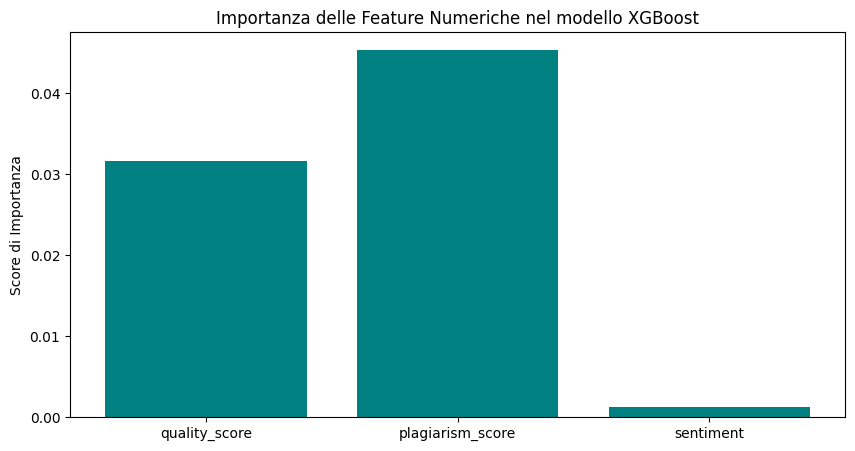

In [56]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sentence_transformers import SentenceTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import StandardScaler

# 1. Caricamento e Preparazione
df = pd.read_csv('ai_human_clean.csv')
embedder = SentenceTransformer("all-MiniLM-L6-v2")

print("Generazione embeddings e preparazione feature...")
text_embeddings = embedder.encode(df['text_cleaned'].tolist())
scaler = StandardScaler()
features_num = scaler.fit_transform(df[['quality_score', 'plagiarism_score', 'sentiment']])

X = np.hstack((text_embeddings, features_num))
y = df['label_encoded']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 2. Addestramento XGBoost
print("Addestramento XGBoost in corso...")
# Usiamo iperparametri standard che funzionano bene per il testo
xgb_model = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    objective='binary:logistic',
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)

xgb_model.fit(X_train, y_train)

# 3. Valutazione
y_pred = xgb_model.predict(X_test)
print(f"\nAccuracy XGBoost: {accuracy_score(y_test, y_pred):.2f}")
print("\nReport di Classificazione:")
print(classification_report(y_test, y_pred, target_names=['Human', 'AI']))

# 4. Feature Importance (Il vero vantaggio di XGBoost)
# Vediamo quali dimensioni del vettore o quali feature numeriche contano di più
import matplotlib.pyplot as plt

# Prendiamo le ultime 3 feature (quality, plagiarism, sentiment)
importances = xgb_model.feature_importances_
num_features_names = ['quality_score', 'plagiarism_score', 'sentiment']
num_importances = importances[-3:]

plt.figure(figsize=(10, 5))
plt.bar(num_features_names, num_importances, color='teal')
plt.title('Importanza delle Feature Numeriche nel modello XGBoost')
plt.ylabel('Score di Importanza')
plt.show()

XGBOOST VS SVM per valutare chi è piu intelligente

Generazione Embeddings...
Addestramento SVM...
Addestramento XGBoost...

Accuracy SVM: 0.9100
Accuracy XGBoost: 0.9100


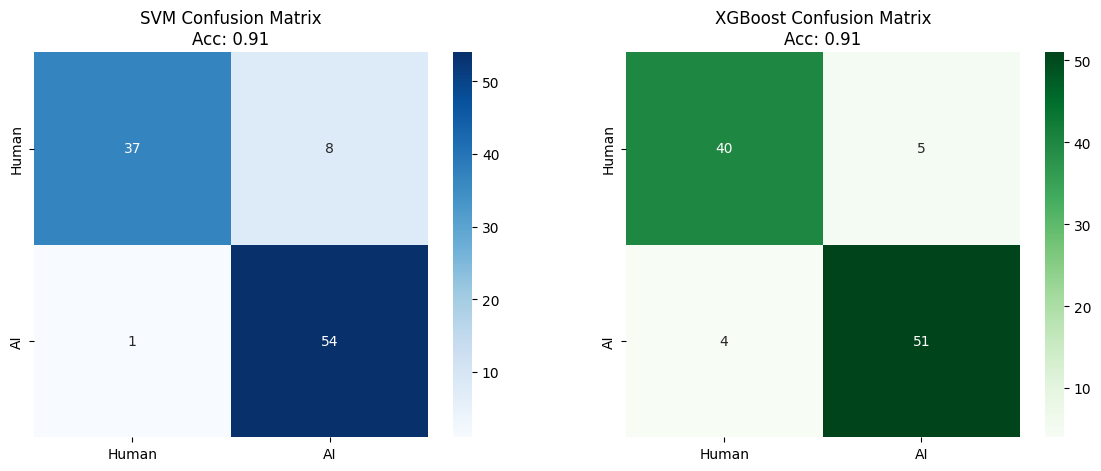

In [59]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from sentence_transformers import SentenceTransformer
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler

# 1. Setup Dati
df = pd.read_csv('ai_human_clean.csv')
embedder = SentenceTransformer("all-MiniLM-L6-v2")

print("Generazione Embeddings...")
text_embeddings = embedder.encode(df['text_cleaned'].tolist())
scaler = StandardScaler()
features_num = scaler.fit_transform(df[['quality_score', 'plagiarism_score', 'sentiment']])

X = np.hstack((text_embeddings, features_num))
y = df['label_encoded']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 2. Addestramento SVM
print("Addestramento SVM...")
svm_model = SVC(kernel='rbf', probability=True, random_state=42)
svm_model.fit(X_train, y_train)
y_pred_svm = svm_model.predict(X_test)

# 3. Addestramento XGBoost
print("Addestramento XGBoost...")
xgb_model = xgb.XGBClassifier(n_estimators=100, max_depth=5, learning_rate=0.1, random_state=42)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)

# 4. Confronto Risultati
acc_svm = accuracy_score(y_test, y_pred_svm)
acc_xgb = accuracy_score(y_test, y_pred_xgb)

print(f"\nAccuracy SVM: {acc_svm:.4f}")
print(f"Accuracy XGBoost: {acc_xgb:.4f}")

# 5. Visualizzazione Matrici di Confusione
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

sns.heatmap(confusion_matrix(y_test, y_pred_svm), annot=True, fmt='d', cmap='Blues', ax=ax[0])
ax[0].set_title(f'SVM Confusion Matrix\nAcc: {acc_svm:.2f}')
ax[0].set_xticklabels(['Human', 'AI']); ax[0].set_yticklabels(['Human', 'AI'])

sns.heatmap(confusion_matrix(y_test, y_pred_xgb), annot=True, fmt='d', cmap='Greens', ax=ax[1])
ax[1].set_title(f'XGBoost Confusion Matrix\nAcc: {acc_xgb:.2f}')
ax[1].set_xticklabels(['Human', 'AI']); ax[1].set_yticklabels(['Human', 'AI'])

plt.show()

Feature Importance- XGBOOTS: scopriamo se XGBoost dà un peso enorme al plagiarism_score o al quality_score, sapremo se il modello non sta capendo il linguaggio, o sta solo cercando anomalie statistiche nei numeri che hai fornito nel CSV.

Generazione Embeddings e mappatura nomi feature...


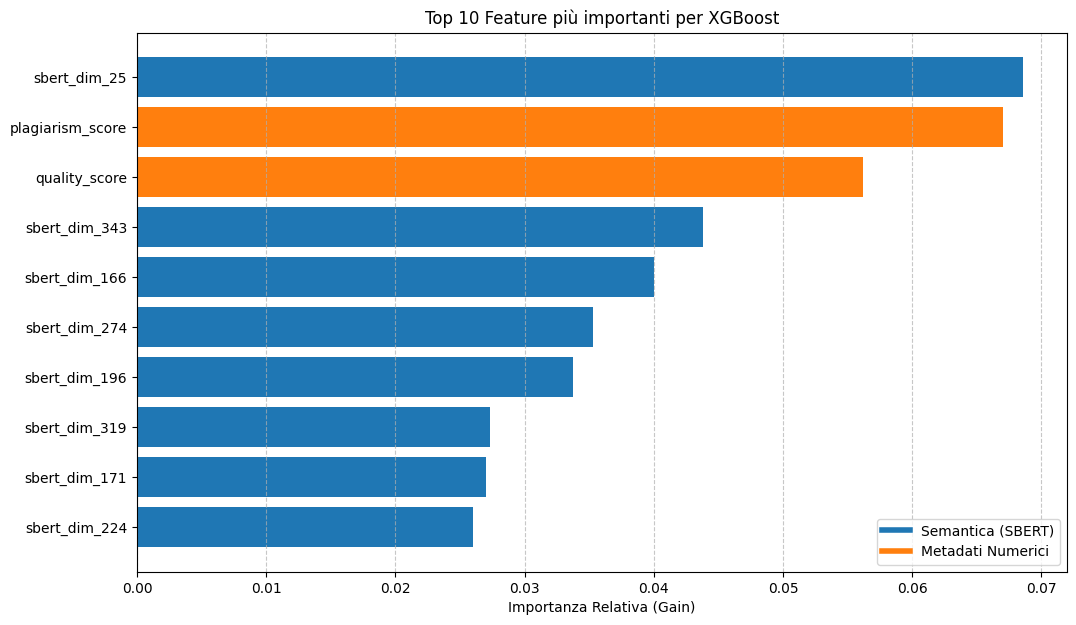


--- ANALISI DEI RISULTATI ---
BUONA NOTIZIA: La feature più importante è 'sbert_dim_25' (SBERT).
Il modello sta dando priorità al contenuto semantico del testo.


In [62]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# 1. Preparazione Dati (stessa procedura dei modelli precedenti)
df = pd.read_csv('ai_human_clean.csv')
embedder = SentenceTransformer("all-MiniLM-L6-v2")

print("Generazione Embeddings e mappatura nomi feature...")
text_embeddings = embedder.encode(df['text_cleaned'].tolist())
scaler = StandardScaler()

# Definiamo i nomi delle feature per chiarezza nel grafico
num_feature_names = ['quality_score', 'plagiarism_score', 'sentiment']
features_num = scaler.fit_transform(df[num_feature_names])

# Creiamo nomi fittizi per i 384 vettori di SBERT (es. dim_0, dim_1, ...)
sbert_feature_names = [f'sbert_dim_{i}' for i in range(text_embeddings.shape[1])]
all_feature_names = sbert_feature_names + num_feature_names

X = np.hstack((text_embeddings, features_num))
y = df['label_encoded']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 2. Addestramento XGBoost
xgb_model = xgb.XGBClassifier(n_estimators=100, max_depth=5, random_state=42)
xgb_model.fit(X_train, y_train)

# 3. Estrazione e Visualizzazione Feature Importance
importances = xgb_model.feature_importances_
feature_importance_df = pd.DataFrame({
    'Feature': all_feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# 4. Grafico delle Top 10
plt.figure(figsize=(12, 7))
top_10 = feature_importance_df.head(10)

# Colore diverso per distinguere testo (SBERT) da numeri (Quality/Sentiment/Plagiarism)
colors = ['#1f77b4' if 'sbert' in f else '#ff7f0e' for f in top_10['Feature']]

plt.barh(top_10['Feature'], top_10['Importance'], color=colors)
plt.gca().invert_yaxis()
plt.title('Top 10 Feature più importanti per XGBoost')
plt.xlabel('Importanza Relativa (Gain)')
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Legenda personalizzata
from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0], color='#1f77b4', lw=4, label='Semantica (SBERT)'),
                   Line2D([0], [0], color='#ff7f0e', lw=4, label='Metadati Numerici')]
plt.legend(handles=legend_elements)

plt.show()

# 5. Commento rapido sui risultati
print("\n--- ANALISI DEI RISULTATI ---")
top_feature = feature_importance_df.iloc[0]['Feature']
if top_feature in num_feature_names:
    print(f"ATTENZIONE: La feature più importante è '{top_feature}'.")
    print("Il modello si sta basando pesantemente sui metadati numerici (BIAS rilevato).")
else:
    print(f"BUONA NOTIZIA: La feature più importante è '{top_feature}' (SBERT).")
    print("Il modello sta dando priorità al contenuto semantico del testo.")

Dominio Arancione: Se le barre arancioni (come plagiarism_score) sono in cima, XGBoost ha trovato una scorciatoia. Ad esempio, se nel dataset l'AI ha sempre un plagio bassissimo e l'umano variabile, XGBoost ignora il testo e guarda solo quel numero. Questo è un limite alla generalizzazione.
Dominio Blu: Se dominano le barre blu, il modello sta analizzando dimensioni specifiche dello spazio vettoriale di SBERT. Ogni "dimensione" rappresenta un concetto astratto (es. formalità, tono, complessità).
L'importanza di sentiment: Spesso il sentiment è un forte discriminatore perché l'AI nel tuo dataset tende a essere molto neutra (intorno allo 0), mentre l'umano è più polarizzato.
Conclusione della tua analisi errori
Ora hai un quadro completo:
-SVM ci ha dato la base statistica.
-XGBoost ci ha mostrato i singoli "perché" matematici dietro le scelte.